In [36]:
import time
start_time = time.time()
import os
import numpy as np
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import adam
from keras import models
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time 
import progressbar
from tqdm.notebook import tqdm_notebook

In [37]:
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [38]:
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
df = pd.read_csv('../../Dataset_original_AMLS_19-20/cartoon_set/labels.csv', sep = '\t')
df = df.drop(columns = [df.columns[0]]).drop(columns = [df.columns[1]])
df['face_shape'] = df['face_shape'].apply(str)
df

,face_shape,file_name
0,4,0.png
1,4,1.png
2,3,2.png
3,0,3.png
4,2,4.png
...,...,...
9995,2,9995.png
9996,3,9996.png
9997,2,9997.png
9998,2,9998.png


In [40]:
img = ('../../Dataset_original_AMLS_19-20/cartoon_set/img')
# training, testing = train_test_split(df, random_state=0)
training, validating, testing = np.split(df.sample(frac=1), [int(.6*len(df)), int(.9*len(df))]) #splitting at n-array
print(training, validating, testing)

     face_shape file_name
1146          3  1146.png
4358          2  4358.png
61            2    61.png
8544          4  8544.png
8077          4  8077.png
...         ...       ...
6735          2  6735.png
1910          3  1910.png
1037          3  1037.png
2926          0  2926.png
2474          0  2474.png

[6000 rows x 2 columns]      face_shape file_name
9306          1  9306.png
1914          3  1914.png
1453          1  1453.png
723           1   723.png
7520          3  7520.png
...         ...       ...
6831          0  6831.png
5831          4  5831.png
5283          3  5283.png
4060          1  4060.png
7112          0  7112.png

[3000 rows x 2 columns]      face_shape file_name
4254          0  4254.png
4511          2  4511.png
8071          2  8071.png
5438          0  5438.png
309           1   309.png
...         ...       ...
1331          4  1331.png
2163          4  2163.png
7597          1  7597.png
5024          3  5024.png
3019          3  3019.png

[1000 rows x 

In [41]:
# set up data generator
data_generator = ImageDataGenerator(
    rescale = 1./255.,
#     validation_split = 0.25,
    horizontal_flip=True,
    vertical_flip=True   
)

# # get batches of training images from the df
# train_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# validate_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# Get batches of training dataset from the dataframe
print("Training Dataset Preparation: ")
train_generator = data_generator.flow_from_dataframe(
        dataframe = training, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training') 
   
# Get batches of validation dataset from the dataframe
print("\nValidation Dataset Preparation: ")
validation_generator = data_generator.flow_from_dataframe(
        dataframe = validating, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training')

Training Dataset Preparation: 
Found 6000 validated image filenames belonging to 5 classes.

Validation Dataset Preparation: 
Found 3000 validated image filenames belonging to 5 classes.


In [42]:
# starting point 
my_model= models.Sequential()

# Add first convolutional block
my_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                    input_shape=(30,30,3))) #height, width, depth
my_model.add(MaxPooling2D((2, 2), padding='same'))
# second block
my_model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) #Convolution: filters, kernel_size that specifies the height and width of the 2D convolution window, p padding layers so dimensions of input = output
my_model.add(MaxPooling2D((2, 2), padding='same'))
# third block
my_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# fourth block
my_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# global average pooling
#my_model.add(GlobalAveragePooling2D())
# fully connected layer
#my_model.add(Dense(64, activation='relu'))
#my_model.add(BatchNormalization())
# make predictions
my_model.add(Flatten())
my_model.add(Dense(5, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 128)        

In [43]:
# # use early stopping to optimally terminate training through callbacks

# es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# # save best model automatically
# mc= ModelCheckpoint('/../../dataset/cartoon_set', monitor='val_loss', 
#                     mode='min', verbose=1, save_best_only=True)
# cb_list=[es,mc]


# compile model 
my_model.compile(optimizer='adam', loss='categorical_crossentropy', 
                 metrics=['accuracy'])


In [44]:
batch_size = 32
history = my_model.fit_generator(
                                train_generator,
                                epochs=25,
                                steps_per_epoch=train_generator.samples // batch_size,
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples // batch_size
                                )

Epoch 1/25
187/187 [==============================] - 31s 168ms/step - loss: 1.5599 - accuracy: 0.2485 - val_loss: 1.0981 - val_accuracy: 0.3807
Epoch 2/25
187/187 [==============================] - 33s 175ms/step - loss: 1.1455 - accuracy: 0.4398 - val_loss: 1.0092 - val_accuracy: 0.4970
Epoch 3/25
187/187 [==============================] - 30s 159ms/step - loss: 0.9330 - accuracy: 0.5788 - val_loss: 0.7393 - val_accuracy: 0.6691
Epoch 4/25
187/187 [==============================] - 30s 163ms/step - loss: 0.6344 - accuracy: 0.7342 - val_loss: 0.6323 - val_accuracy: 0.7746
Epoch 5/25
187/187 [==============================] - 31s 164ms/step - loss: 0.4733 - accuracy: 0.8070 - val_loss: 0.8459 - val_accuracy: 0.8261
Epoch 6/25
187/187 [==============================] - 32s 171ms/step - loss: 0.4085 - accuracy: 0.8361 - val_loss: 0.3623 - val_accuracy: 0.8518
Epoch 7/25
187/187 [==============================] - 35s 187ms/step - loss: 0.3142 - accuracy: 0.8807 - val_loss: 0.2238 - val_ac

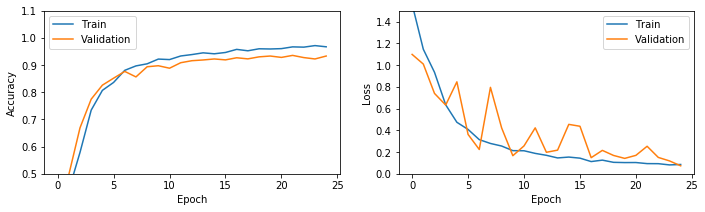

In [45]:
plt.figure(figsize=(18, 3))

plt.subplot(131)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([.5,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(132)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0,1.5])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')

plt.savefig("Custom_Keras_ODSC.png", dpi=300)

In [46]:
from keras.models import load_model

modelFile = 'my_CNN.h5'

# model_path = os.path.abspath(os.curdir)
# file_path = os.path.join(model_path, modelFile)
my_model.save(modelFile)

In [47]:
os.getcwd()

'C:\\Users\\User\\Desktop\\4th_year_AMLS\\zceecyt-AMLSassignment19_20-16053203\\Project-16053203\\Notebook\\B1'

In [48]:
df2 = pd.read_csv('../../Dataset_test_AMLS_19-20/cartoon_set_test/labels.csv', sep = '\t')
df2 = df2.drop(columns = [df2.columns[0]]).drop(columns = [df2.columns[1]])
df2['face_shape'] = df2['face_shape'].apply(str)
df2

,face_shape,file_name
0,1,0.png
1,4,1.png
2,2,2.png
3,2,3.png
4,3,4.png
...,...,...
2495,4,2495.png
2496,4,2496.png
2497,4,2497.png
2498,4,2498.png


In [49]:
img = ('../../Dataset_test_AMLS_19-20/cartoon_set_test/img')

In [50]:
# saved_model = load_model(modelFile)
# test_generator = data_generator.flow_from_dataframe(
#         dataframe = testing, directory = img,
#         x_col = "file_name", y_col = "face_shape",
#         batch_size=1,
#         class_mode='categorical', target_size=(30, 30),
#         shuffle=False)
# test_steps = test_generator.samples
# print(test_steps)

saved_model = load_model(modelFile)
test_generator = data_generator.flow_from_dataframe(
        dataframe = df2, directory = img,
        x_col = "file_name", y_col = "face_shape",
        batch_size=1,
        class_mode='categorical', target_size=(30, 30),
        shuffle=False)
test_steps = test_generator.samples
print(test_steps)

Found 2500 validated image filenames belonging to 5 classes.
2500


In [51]:
test_generator.reset()
pred=saved_model.predict_generator(test_generator, verbose=1, steps=test_steps)
# determine the maximum activation value for each sample
predicted_class_indices=np.argmax(pred,axis=1)
# print(predicted_class_indices)
# label each predicted value to correct gender
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# # format file names to simply male or female
# filenames=test_generator.filenames
# filenz=[0]
# for i in range(0,len(filenames)):
#     filenz.append(filenames[i].split('\\')[0])
# filenz=filenz[1:]

# # determine the test set accuracy
# match=[]
# for i in range(0,len(filenames)):
#     match.append(filenz[i]==predictions[i])
# match.count(True)/1000



2500/2500 [==============================] - 23s 9ms/step


In [52]:
import sklearn.metrics as metrics

[[414  66   5  12   3]
 [ 15 457   1  25   2]
 [  4   3 491   2   0]
 [  1  16   0 479   4]
 [  0   4   2  19 475]]

Confusion Matrix


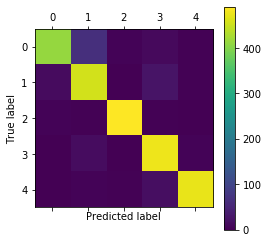

[[0.1656 0.0264 0.002  0.0048 0.0012]
 [0.006  0.1828 0.0004 0.01   0.0008]
 [0.0016 0.0012 0.1964 0.0008 0.    ]
 [0.0004 0.0064 0.     0.1916 0.0016]
 [0.     0.0016 0.0008 0.0076 0.19  ]]

Confusion Matrix (normalised)


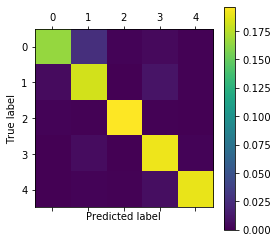

Classification report

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       500
           1       0.84      0.91      0.87       500
           2       0.98      0.98      0.98       500
           3       0.89      0.96      0.92       500
           4       0.98      0.95      0.97       500

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500

Accuracy achieved: 0.9264 ♡♡♡


In [53]:
#confusion matrix and classification report

#Y_pred = my_model.predict_generator(test_generator, test_generator.samples // batch_size+1)
#y_pred = np.argmax(Y_pred, axis=1)


#target_names = ['0','1','2','3','4']
#print(classification_report(test_generator.classes, y_pred, target_names=target_names))

cm = confusion_matrix(test_generator.classes, predicted_class_indices)

print(cm)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix')
plt.show()


cm2 = confusion_matrix(test_generator.classes, predicted_class_indices, normalize='all')

print(cm2)
plt.matshow(cm2)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix (normalised)')
plt.show()

print('Classification report\n')
print(classification_report(test_generator.classes, predicted_class_indices))
print('Accuracy achieved:', accuracy_score(test_generator.classes, predicted_class_indices), '\u2661''\u2661''\u2661')

In [54]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 821.8901991844177 seconds ---
